<a href="https://colab.research.google.com/github/spemmaraju5/ibm-datascience-profcert/blob/main/NYCTaxiFarePred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Read in the data
test_data = pd.read_csv("/content/drive/MyDrive/new-york-city-taxi-fare-prediction/test.csv")


training_data = pd.read_csv("/content/drive/MyDrive/new-york-city-taxi-fare-prediction/train.csv", nrows = 20000)

#Split up datetime_pickup into DD MM YYYY HMS. New columns
training_data['pickup_year'] = training_data['pickup_datetime'].str[:4].astype(int)
training_data['pickup_month'] = training_data['pickup_datetime'].str[5:7].astype(int)
training_data['pickup_day'] = training_data['pickup_datetime'].str[8:10].astype(int)
training_data['pickup_time_hrs'] = training_data['pickup_datetime'].str[11:13].astype(int)
training_data['pickup_time_mins'] = training_data['pickup_datetime'].str[14:16].astype(int)
keys = training_data['key']
trip_dates = training_data['pickup_datetime'].str[:10]
training_data = training_data.drop(columns = ['pickup_datetime', 'key'])


Visualise the correlation between the target and the features to see if we can drop anything else

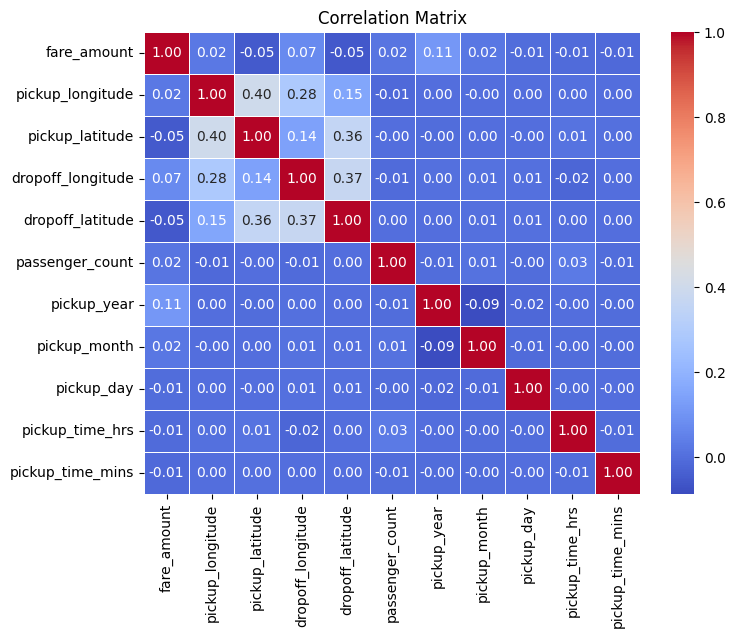

In [17]:
training_data_corr = training_data.corr(method = 'kendall')
plt.figure(figsize=(8, 6))
sns.heatmap(training_data_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The date and time of the pickup don't seem to be correlated to the fare amount. The year in which the pickup happened seems to exhibit a stronger correlation with the fair amount.

In [18]:
training_data = training_data.drop(columns = ['pickup_month', 'pickup_day', 'pickup_time_hrs', 'pickup_time_mins'])

In [19]:
training_data
# Split data into features and target variables
y_train = training_data['fare_amount']
X_train = training_data.drop(columns = 'fare_amount')

#Feature engineering based on distances between pickup and dropoff points and the day of the week
!pip install geopy
from scipy.spatial import distance

def calculate_distance(row):
  pickup_location = (row['pickup_latitude'], row['pickup_longitude'])
  dropoff_location = (row['dropoff_latitude'], row['dropoff_longitude'])

  return distance.euclidean(pickup_location, dropoff_location)*111

X_train['distance_km'] = X_train.apply(calculate_distance, axis = 1)

#Day of the Week
from datetime import datetime
X_train = pd.concat([X_train, trip_dates], axis = 1)
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])
X_train['day_of_week'] = X_train['pickup_datetime'].dt.dayofweek

In [20]:
X_train = X_train.drop(columns = 'pickup_datetime')
X_train

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,distance_km,day_of_week
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,1.047378,0
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,8.846219,1
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,1.517818,3
3,-73.987130,40.733143,-73.991567,40.758092,1,2012,2.812792,5
4,-73.968095,40.768008,-73.956655,40.783762,1,2010,2.161116,1
...,...,...,...,...,...,...,...,...
19995,-73.985163,40.747282,-73.974358,40.743270,2,2011,1.279364,1
19996,-73.783457,40.648702,-73.954360,40.620647,1,2013,19.224136,0
19997,-74.015404,40.709366,-73.978844,40.764610,1,2015,7.353351,5
19998,-73.973275,40.760405,-73.984875,40.711660,1,2011,5.561792,4


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state = 42)
#model.fit(X_train, y_train)

#Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of a tree
    'subsample': [0.7, 0.8, 1.0],         # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 1.0]   # Subsample ratio of columns when constructing each tree
}

# Initialize GridSearchCV with XGBRegressor
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5,
                           n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


#Re-format the test data to match the shape of the training data
test_data['pickup_year'] = test_data['key'].str[:4].astype(int)
test_data['distance_km'] = test_data.apply(calculate_distance, axis = 1)
test_data['pickup_date'] = pd.to_datetime(test_data['pickup_datetime'].str[:10])
test_keys = test_data['key']

test_data['day_of_week'] = test_data['pickup_date'].dt.dayofweek
test_data = test_data.drop(columns = ['pickup_date', 'key', 'pickup_datetime'])
test_data

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
X_test = test_data

y_pred = best_model.predict(X_test)

# Make a dataframe with key and y_pred and save this as a CSV file
result_df = pd.concat([test_keys, y_pred], axis = 1)
result_df.columns = ['key', 'fare_amount']
filepath = '/content/drive/MyDrive/new-york-city-taxi-fare-prediction/nyc_taxifarepred.csv'
result_df.to_csv(filepath, index = False)

result_df